In [ ]:
#@title Code that will set everything working for that exercise. It's good to have a look on it, though.
%tensorflow_version 2.x

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()



## Load the datasets from the internet

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

In [ ]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

## Task 1: Normalize values

When creating a model with multiple features, the values of each feature should cover roughly the same range.  For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should normalize features in a multi-feature model. 

The following code cell normalizes datasets by converting each raw value (including the label) to its Z-score. See labs notes for more detalis. As a recap, s **Z-score** is the number of standard deviations from the mean for a particular raw value. For example, consider a feature having the following characteristics:

  * The mean is 60.
  * The standard deviation is 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

**HINT:** make use of the `mean()` and `std()` already implemented functions by calling them directly on the data obtained using pandas! 
Also, make use of the operators on data! For example, if we have two different `train_df_1` and `train_df_2`, what is the result of `train_df_1 + train_df_2`? ;)

In [ ]:
train_df_means = train_df.mean(0)
train_df_stds = train_df.std(0)

In [ ]:
train_df_norm = (train_df - train_df_means) / train_df_stds
test_df_norm = (test_df - train_df_means) / train_df_stds

## Task 2: Create a binary label

We should answer the question "Are houses in a given neighborhood above a certain price?" There are two class, based on the given price! 

In binary classification problems, the label for every example must be **either 0 or 1**. Unfortunately, the natural label in the California Housing Dataset, `median_house_value`, contains floating-point values like 80,100 or 85,700 rather than 0s and 1s, while the normalized version of `median_house_values` contains floating-point values primarily between -3 and +3.

**We should tarnsform natural label values using the "certain price"!**

**As an intuition, what we are triyng to do here is transforming a regression problem (that predicts the price) into a classification problem (that predicts if the price is above a given one).**

Your task is to create a new column named `median_house_value_is_high` in both the training set and the test set . If the `median_house_value` is higher than a certain arbitrary value (defined by `threshold`), then set `median_house_value_is_high` to 1. Otherwise, set `median_house_value_is_high` to 0. 

The threshold represents, in fact, the given price based on which we make our classification. If it's higher then the threshold, than we could say that the house price is too high. 

**Hint 1:** The cells in the `median_house_value_is_high` column must each hold `1` and `0`, not `True` and `False`. To convert `True` and `False` to  `1` and `0`, call the pandas DataFrame function `astype(float)`. 

**Hint 2:** A good threshold could be `265000` (i.e. the 75th percentile for median house values).


In [ ]:
threshold = np.percentile(train_df.median_house_value, 75)
threshold_func = lambda val: int(val > threshold)
train_df_norm['median_house_value_is_high'] = train_df.median_house_value.apply(threshold_func)
test_df_norm['median_house_value_is_high'] = test_df.median_house_value.apply(threshold_func)

## Take only the representive features from dataset

We will specify ` median_income`  and ` total_rooms` as features you'll ultimately train the model on. We will introduce the features in the so called ` feature_layer` from which the training is performed.

In [ ]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[-0.33203676, -0.9631722 ],
       [-0.93680894, -0.5461896 ],
       [-0.07938453, -0.90766627],
       ...,
       [ 1.91846   , -0.24021886],
       [ 0.18175757, -0.13929899],
       [-1.4833574 , -0.8374811 ]], dtype=float32)>

## Functions that build and train a model

The following code defines two functions:

  * `create_model(my_learning_rate, feature_layer, my_metrics)`, which defines the model's
    topography.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

**Note:** In the regression example discussed during the last laboratory, we used ReLU as activation function. This exercise uses sigmoid as the activation function, being one of the good practices in terms of classification tasks. The sigmoid will keep values between 0 and 1, associating it to a probability distribution, which could easily be transformed to a classifier.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/20
170/170 [==============================] - 2s 4ms/step - loss: 1.1306 - accuracy: 0.2391
Epoch 2/20
170/170 [==============================] - 1s 7ms/step - loss: 1.0216 - accuracy: 0.2559
Epoch 3/20
170/170 [==============================] - 1s 4ms/step - loss: 0.9226 - accuracy: 0.2814
Epoch 4/20
170/170 [==============================] - 1s 6ms/step - loss: 0.8351 - accuracy: 0.3291
Epoch 5/20
170/170 [==============================] - 1s 5ms/step - loss: 0.7591 - accuracy: 0.4081
Epoch 6/20
170/170 [==============================] - 1s 4ms/step - loss: 0.6933 - accuracy: 0.5460
Epoch 7/20
170/170 [==============================] - 1s 5ms/step - loss: 0.6381 - accuracy: 0.6686
Epoch 8/20
170/170 [==============================] - 1s 6ms/step - loss: 0.5920 - accuracy: 0.7124
Epoch 9/20
170/170 [==============================] - 1s 6ms/step - loss: 0.5510 - accuracy: 0.7343
Epoch 10/20
170/170 [==============================] - 1s 4ms/step - loss: 0.5167 - accuracy: 0.7681

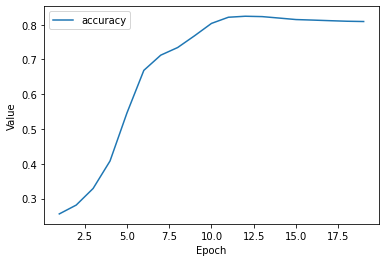

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

## Evaluate the model against the test set

At the end of model training, you ended up with a certain accuracy against the *training set*. Invoke the following code cell to determine your model's accuracy against the *test set*.

In [ ]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

30/30 [==============================] - 0s 2ms/step - loss: 0.4073 - accuracy: 0.8033


[0.4073478579521179, 0.8033333420753479]

## Task 3: Create a validation set and find the losses and accuracies performed on that set. How accurate is your model really?

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


136/136 [==============================] - 1s 4ms/step - loss: 0.5908 - accuracy: 0.3135
Epoch 2/20
136/136 [==============================] - 0s 2ms/step - loss: 0.5464 - accuracy: 0.4788
Epoch 3/20
136/136 [==============================] - 0s 2ms/step - loss: 0.5101 - accuracy: 0.5987
Epoch 4/20
136/136 [==============================] - 0s 2ms/step - loss: 0.4803 - accuracy: 0.6710
Epoch 5/20
136/136 [==============================] - 0s 2ms/step - loss: 0.4564 - accuracy: 0.7170
Epoch 6/20
136/136 [==============================] - 0s 2ms/step - loss: 0.4378 - accuracy: 0.7461
Epoch 7/20
136/136 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.7669
Epoch 8/20
136/136 [==============================] - 0s 2ms/step - loss: 0.4137 - accuracy: 0.7816
Epoch 9/20
136/136 [==============================] - 0s 2ms/step - loss: 0.4071 - accuracy: 0.7893
Epoch 10/20
136/136 [==============================] - 0s 2ms/step - loss: 0.4029 - accuracy: 0.7970
Epoch 11/2

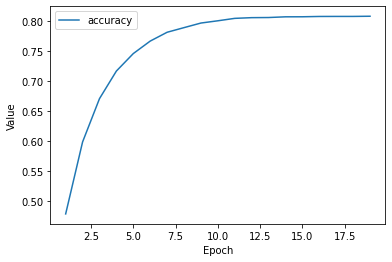

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

validation_split=0.2

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

shuffled_train_df = train_df_norm.reindex(np.random.permutation(train_df_norm.index))
shuffled_val_df = shuffled_train_df[:int(validation_split * len(train_df_norm))]
shuffled_train_df = shuffled_train_df[int(validation_split * len(train_df_norm)):]


# Train the model on the training set.
epochs, hist = train_model(my_model, shuffled_train_df, epochs, 
                           label_name, batch_size, validation_split)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

In [ ]:
# Validation
features = { name:np.array(value) for name, value in shuffled_val_df.items() }
label = np.array(features.pop(label_name))
my_model.evaluate(x = features, y = label, batch_size=batch_size)

34/34 [==============================] - 0s 2ms/step - loss: 0.3957 - accuracy: 0.8150


[0.3956662118434906, 0.8149999976158142]

In [ ]:
# Test
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))
my_model.evaluate(x = features, y = label, batch_size=batch_size)

30/30 [==============================] - 0s 3ms/step - loss: 0.4070 - accuracy: 0.8050


[0.4070398807525635, 0.8050000071525574]

## Task 4: Add precision and recall as metrics. Find the values for all metrics on each splitted data set (train, validation and test). Interpret the results.

Relying solely on accuracy, particularly for a class-imbalanced data set (like ours), can be a poor way to judge a classification model.  Modify the code in the following code cell to enable the model to measure not only accuracy but also precision and recall. 



In [ ]:
import sklearn.metrics as metrics

In [ ]:
def get_precision_recall(df, label_name):
  features = { name:np.array(value) for name, value in df.items() }
  label = np.array(features.pop(label_name))
  y_pred = my_model.predict(x = features, batch_size=batch_size)
  precision = metrics.precision_score(label, y_pred > classification_threshold)
  recall = metrics.recall_score(label, y_pred > classification_threshold)
  print("Precision: ", precision)
  print("Recall: ", recall)

In [ ]:
# Train
get_precision_recall(shuffled_train_df, label_name)

Precision:  0.6171782762691853
Recall:  0.6137364250073378


In [ ]:
# Valid
get_precision_recall(shuffled_val_df, label_name)

Precision:  0.6278787878787879
Recall:  0.6166666666666667


In [ ]:
# Test
get_precision_recall(test_df_norm, label_name)

Precision:  0.6168359941944848
Recall:  0.5697050938337802


## Task 5: Experiment with the classification threshold. Give conclusions on what performance you get using different classification thresholds.

Experiment with different values for `classification_threshold`.  What value of `classification_threshold` produces the highest accuracy?

In [ ]:
def get_metrics(df, label_name, classification_threshold):
  features = { name:np.array(value) for name, value in df.items() }
  label = np.array(features.pop(label_name))
  y_pred = my_model.predict(x = features, batch_size=batch_size)
  precision = metrics.precision_score(label, y_pred > classification_threshold)
  recall = metrics.recall_score(label, y_pred > classification_threshold)
  acc = metrics.accuracy_score(label, y_pred > classification_threshold)
  print("Precision: ", precision)
  print("Recall: ", recall)
  print("Accuracy: ", acc)

In [ ]:
for i in range(20):
  print('Threshold: ', i * 0.05)
  get_metrics(shuffled_val_df, label_name, i * 0.05)
  print('\n\n')

Threshold:  0.0
Precision:  0.24705882352941178
Recall:  1.0
Accuracy:  0.24705882352941178



Threshold:  0.05
Precision:  0.2893059490084986
Recall:  0.9726190476190476
Accuracy:  0.40294117647058825



Threshold:  0.1
Precision:  0.3572093023255814
Recall:  0.9142857142857143
Accuracy:  0.5723529411764706



Threshold:  0.15000000000000002
Precision:  0.4200119832234871
Recall:  0.8345238095238096
Accuracy:  0.6744117647058824



Threshold:  0.2
Precision:  0.47171197648787655
Recall:  0.7642857142857142
Accuracy:  0.7302941176470589



Threshold:  0.25
Precision:  0.5268336314847942
Recall:  0.7011904761904761
Accuracy:  0.7705882352941177



Threshold:  0.30000000000000004
Precision:  0.5810526315789474
Recall:  0.6571428571428571
Accuracy:  0.798235294117647



Threshold:  0.35000000000000003
Precision:  0.6278787878787879
Recall:  0.6166666666666667
Accuracy:  0.815



Threshold:  0.4
Precision:  0.6680911680911681
Recall:  0.5583333333333333
Accuracy:  0.8223529411764706



Thr

As seen, the best accuracy (on validation) we got using 0.55 as threshold

## Task 6: Summarize model performance

Add one more metric that attempts to summarize the model's overall performance. AUC could be a good choice, interpret the model's overall performance using AUC.

In [ ]:
def get_auc(df, label_name):
  features = { name:np.array(value) for name, value in df.items() }
  label = np.array(features.pop(label_name))
  y_pred = my_model.predict(x = features, batch_size=batch_size)
  auc = metrics.roc_auc_score(label, y_pred)
  print("AUC: ", auc)

In [ ]:
# Train
get_auc(shuffled_train_df, label_name)

AUC:  0.837800828512209


In [ ]:
# Validation
get_auc(shuffled_val_df, label_name)

AUC:  0.8335407366071429


In [ ]:
# Test
get_auc(test_df_norm, label_name)

AUC:  0.8264128591173034
